In [1]:
# 필요한 라이브러리 로드
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

In [ ]:
# 한글 폰트 설정
candidates = [
    "AppleGothic",        # macOS
    "Malgun Gothic",      # Windows
    "NanumGothic", "Nanum Gothic", "Noto Sans CJK KR", "Noto Sans KR"  # Linux 등
]
for name in candidates:
    try:
        # 폰트가 실제로 존재하는지 확인
        font_path = font_manager.findfont(name, fallback_to_default=False)
        if os.path.exists(font_path):
            rcParams["font.family"] = name
            break
    except Exception:
        continue
# 마이너스 기호 깨짐 방지
rcParams["axes.unicode_minus"] = False

# 상관분석
def corr_and_heatmap(df: pd.DataFrame, feature_cols, out_dir, pilename):
    """피어슨 상관행렬 CSV와 히트맵 PNG 저장(EDA 목적)"""
    os.makedirs(out_dir, exist_ok=True)
    corr = df[feature_cols].corr(method="pearson")
    csv_path = os.path.join(out_dir, f"{pilename}_corr.csv")
    png_path = os.path.join(out_dir, f"{pilename}_corr.png")
    corr.to_csv(csv_path, encoding="utf-8-sig")

    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.title(f"Pearson Correlation ({pilename})")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
    plt.yticks(range(len(corr.index)),   corr.index,   fontsize=7)
    plt.tight_layout()
    plt.savefig(png_path, dpi=200)
    plt.show()

In [ ]:
# 데이터 로드
market = pd.read_csv('data/상장.csv')
unlist = pd.read_csv('data/비상장.csv')
all = pd.read_csv('data/all.csv')

In [8]:
# feature가 아닌 컬럼
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']

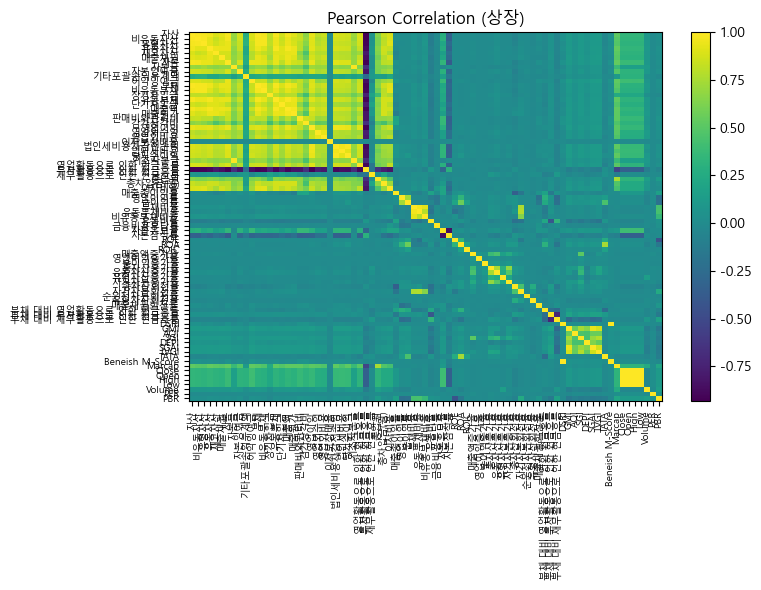

In [21]:
corr_and_heatmap(market, market.drop(drop_cols, axis=1).columns, 'heatmap', '상장')

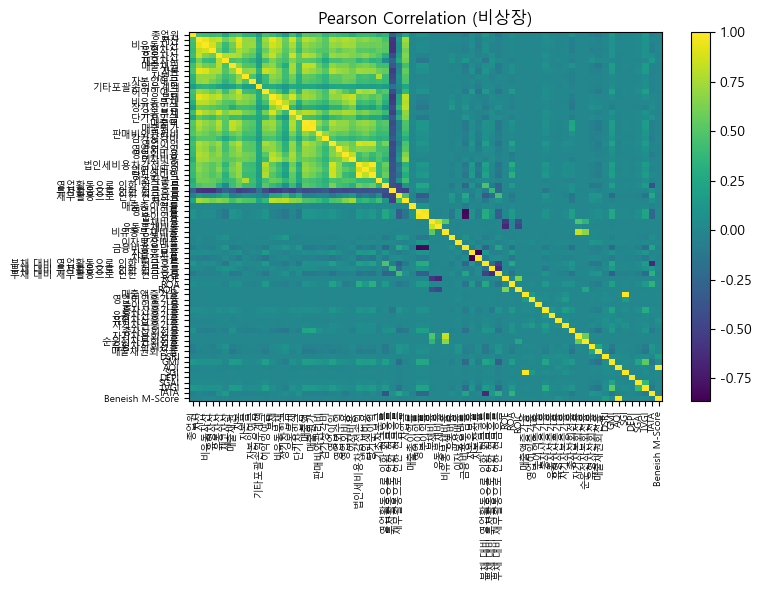

In [22]:
corr_and_heatmap(unlist,unlist.drop(drop_cols, axis=1).columns, 'heatmap', '비상장')

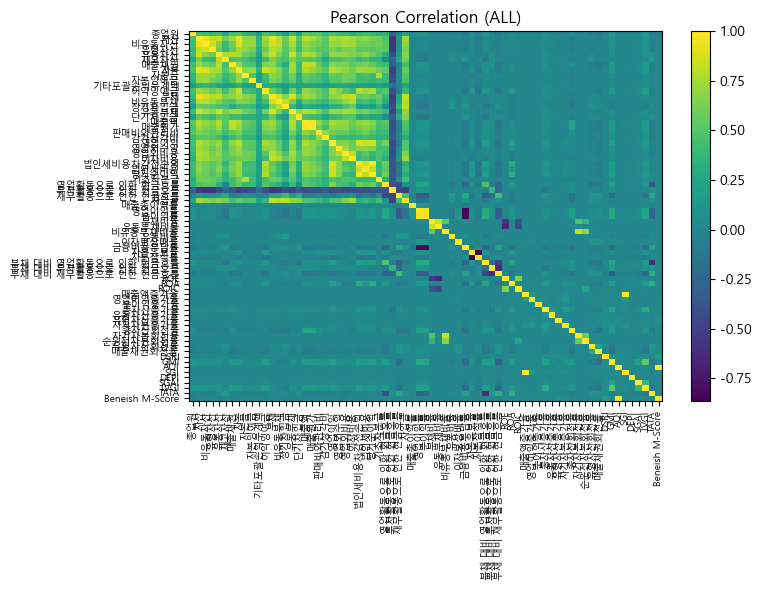

In [23]:
corr_and_heatmap(unlist,unlist.drop(drop_cols, axis=1).columns, 'heatmap', 'ALL')

In [24]:
# PCA
import pandas as pd
from sklearn.decomposition import SparsePCA
from scipy.stats import yeojohnson

df = pd.read_csv('data/상장.csv')

data = pd.DataFrame(index=df.index)
for col in df.drop(['회사명', '회계년도', '거래소코드', '산업코드', '산업명', 'label'], axis=1).columns :
    transformed_data, lambda_ = yeojohnson(df[col])
    data[col] = transformed_data
data['label'] = df['label']

# 1. Sparse PCA 수행
n_components = 5   # 주성분 개수
max_features_per_pc = 3  # 각 PC에서 사용할 최대 피처 수
X = data.drop(columns=["label"])
spca = SparsePCA(n_components=n_components, alpha=1, random_state=42)
spca.fit(X)

# 2. 로딩 확인 (피처 x PC)
sparse_loadings = pd.DataFrame(
    spca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# 3. 절대값 기준으로 상위 피처 선택 (중복 방지)
selected_features = set()
top_features_per_pc = {}

for pc in sparse_loadings.columns:
    # 남은 피처만 고려
    remaining_features = sparse_loadings.index.difference(selected_features)
    # 남은 피처 중 절대값 기준 상위 N개 선택
    top_features = sparse_loadings.loc[remaining_features, pc].abs().sort_values(ascending=False).head(max_features_per_pc).index.tolist()
    top_features_per_pc[pc] = top_features
    selected_features.update(top_features)

# 4. 결과 확인
print(top_features_per_pc)

for pc in sparse_loadings.columns:
    print(f"\n{pc} 상위 기여 피처:")
    print(sparse_loadings[pc].abs().sort_values(ascending=False).head(5))

pc_variances = pd.Series([X.dot(spca.components_[i,:]).var() for i in range(n_components)],
                         index=[f'PC{i+1}' for i in range(n_components)])
# 전체 분산 대비 비율
pc_variance_ratio = pc_variances / pc_variances.sum()
print(pc_variance_ratio)

{'PC1': ['이익잉여금', '법인세비용차감전손익', '영업활동으로 인한 현금흐름'], 'PC2': ['재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '자본'], 'PC3': ['당기순이익', '영업이익', '법인세비용'], 'PC4': ['기타포괄손익누계액', '이자비용', '순운전자본회전율'], 'PC5': ['자본유보율', '자본잠식률', '부채비율']}

PC1 상위 기여 피처:
이익잉여금             0.784577
법인세비용차감전손익        0.298904
영업활동으로 인한 현금흐름    0.282918
투자활동으로 인한 현금흐름    0.261926
당기순이익             0.253645
Name: PC1, dtype: float64

PC2 상위 기여 피처:
재무활동으로 인한 현금흐름    0.963956
영업활동으로 인한 현금흐름    0.193299
투자활동으로 인한 현금흐름    0.159730
이익잉여금             0.055600
자본                0.039735
Name: PC2, dtype: float64

PC3 상위 기여 피처:
영업활동으로 인한 현금흐름    0.590095
이익잉여금             0.568933
투자활동으로 인한 현금흐름    0.426944
법인세비용차감전손익        0.266283
당기순이익             0.220065
Name: PC3, dtype: float64

PC4 상위 기여 피처:
법인세비용차감전손익        0.602574
당기순이익             0.542344
영업활동으로 인한 현금흐름    0.439290
투자활동으로 인한 현금흐름    0.307681
이익잉여금             0.170664
Name: PC4, dtype: float64

PC5 상위 기여 피처:
투자활동으로 인한 현금흐름    0.703933
영업활동으로 인한 현금흐름    0.534488
기타포괄손익누계액    

In [27]:
data1_feature_cols = ['이익잉여금', '법인세비용차감전손익', '영업활동으로 인한 현금흐름', '재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '자본']

In [25]:
df = pd.read_csv('data/비상장.csv')

data = pd.DataFrame(index=df.index)
for col in df.drop(['회사명', '회계년도', '거래소코드', '산업코드', '산업명', 'label'], axis=1).columns :
    transformed_data, lambda_ = yeojohnson(df[col])
    data[col] = transformed_data
data['label'] = df['label']

# 1. Sparse PCA 수행
n_components = 5   # 주성분 개수
max_features_per_pc = 3  # 각 PC에서 사용할 최대 피처 수
X = data.drop(columns=["label"])
spca = SparsePCA(n_components=n_components, alpha=1, random_state=42)
spca.fit(X)

# 2. 로딩 확인 (피처 x PC)
sparse_loadings = pd.DataFrame(
    spca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# 3. 절대값 기준으로 상위 피처 선택 (중복 방지)
selected_features = set()
top_features_per_pc = {}

for pc in sparse_loadings.columns:
    # 남은 피처만 고려
    remaining_features = sparse_loadings.index.difference(selected_features)
    # 남은 피처 중 절대값 기준 상위 N개 선택
    top_features = sparse_loadings.loc[remaining_features, pc].abs().sort_values(ascending=False).head(max_features_per_pc).index.tolist()
    top_features_per_pc[pc] = top_features
    selected_features.update(top_features)

# 4. 결과 확인
print(top_features_per_pc)

for pc in sparse_loadings.columns:
    print(f"\n{pc} 상위 기여 피처:")
    print(sparse_loadings[pc].abs().sort_values(ascending=False).head(5))

pc_variances = pd.Series([X.dot(spca.components_[i,:]).var() for i in range(n_components)],
                         index=[f'PC{i+1}' for i in range(n_components)])
# 전체 분산 대비 비율
pc_variance_ratio = pc_variances / pc_variances.sum()
print(pc_variance_ratio)

{'PC1': ['이익잉여금', '자본', '영업활동으로 인한 현금흐름'], 'PC2': ['재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '영업이익'], 'PC3': ['법인세비용차감전손익', '당기순이익', '기타포괄손익누계액'], 'PC4': ['법인세비용', '순이익률', '이자보상배율'], 'PC5': ['AQI', 'Beneish M-Score', '부채비율']}

PC1 상위 기여 피처:
이익잉여금             0.647127
자본                0.614834
영업활동으로 인한 현금흐름    0.302809
법인세비용차감전손익        0.191068
당기순이익             0.169633
Name: PC1, dtype: float64

PC2 상위 기여 피처:
재무활동으로 인한 현금흐름    0.818501
영업활동으로 인한 현금흐름    0.456783
이익잉여금             0.211290
투자활동으로 인한 현금흐름    0.210288
자본                0.174523
Name: PC2, dtype: float64

PC3 상위 기여 피처:
이익잉여금             0.556486
영업활동으로 인한 현금흐름    0.547114
투자활동으로 인한 현금흐름    0.469405
자본                0.313002
재무활동으로 인한 현금흐름    0.261436
Name: PC3, dtype: float64

PC4 상위 기여 피처:
자본                0.697683
영업활동으로 인한 현금흐름    0.414579
이익잉여금             0.391065
투자활동으로 인한 현금흐름    0.348819
재무활동으로 인한 현금흐름    0.197485
Name: PC4, dtype: float64

PC5 상위 기여 피처:
법인세비용차감전손익        0.652035
당기순이익             0.583107
영업이익   

In [28]:
data2_feature_cols = ['이익잉여금', '자본', '영업활동으로 인한 현금흐름', '재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '영업이익']

In [26]:
df = pd.read_csv('data/ALL.csv')

data = pd.DataFrame(index=df.index)
for col in df.drop(['회사명', '회계년도', '거래소코드', '산업코드', '산업명', 'label'], axis=1).columns :
    transformed_data, lambda_ = yeojohnson(df[col])
    data[col] = transformed_data
data['label'] = df['label']

# 1. Sparse PCA 수행
n_components = 5   # 주성분 개수
max_features_per_pc = 3  # 각 PC에서 사용할 최대 피처 수
X = data.drop(columns=["label"])
spca = SparsePCA(n_components=n_components, alpha=1, random_state=42)
spca.fit(X)

# 2. 로딩 확인 (피처 x PC)
sparse_loadings = pd.DataFrame(
    spca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# 3. 절대값 기준으로 상위 피처 선택 (중복 방지)
selected_features = set()
top_features_per_pc = {}

for pc in sparse_loadings.columns:
    # 남은 피처만 고려
    remaining_features = sparse_loadings.index.difference(selected_features)
    # 남은 피처 중 절대값 기준 상위 N개 선택
    top_features = sparse_loadings.loc[remaining_features, pc].abs().sort_values(ascending=False).head(max_features_per_pc).index.tolist()
    top_features_per_pc[pc] = top_features
    selected_features.update(top_features)

# 4. 결과 확인
print(top_features_per_pc)

for pc in sparse_loadings.columns:
    print(f"\n{pc} 상위 기여 피처:")
    print(sparse_loadings[pc].abs().sort_values(ascending=False).head(5))

pc_variances = pd.Series([X.dot(spca.components_[i,:]).var() for i in range(n_components)],
                         index=[f'PC{i+1}' for i in range(n_components)])
# 전체 분산 대비 비율
pc_variance_ratio = pc_variances / pc_variances.sum()
print(pc_variance_ratio)

{'PC1': ['이익잉여금', '자본', '영업활동으로 인한 현금흐름'], 'PC2': ['재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '법인세비용차감전손익'], 'PC3': ['영업이익', '당기순이익', '법인세비용'], 'PC4': ['기타포괄손익누계액', '이자비용', '순이익률'], 'PC5': ['이자보상배율', '순운전자본회전율', 'AQI']}

PC1 상위 기여 피처:
이익잉여금             0.711610
자본                0.450579
영업활동으로 인한 현금흐름    0.317925
법인세비용차감전손익        0.254199
투자활동으로 인한 현금흐름    0.231950
Name: PC1, dtype: float64

PC2 상위 기여 피처:
재무활동으로 인한 현금흐름    0.938554
영업활동으로 인한 현금흐름    0.291736
투자활동으로 인한 현금흐름    0.145529
이익잉여금             0.074911
자본                0.072917
Name: PC2, dtype: float64

PC3 상위 기여 피처:
영업활동으로 인한 현금흐름    0.683406
이익잉여금             0.569462
투자활동으로 인한 현금흐름    0.369644
재무활동으로 인한 현금흐름    0.185787
자본                0.130154
Name: PC3, dtype: float64

PC4 상위 기여 피처:
법인세비용차감전손익        0.662307
당기순이익             0.581588
영업활동으로 인한 현금흐름    0.317811
이익잉여금             0.268936
영업이익              0.148979
Name: PC4, dtype: float64

PC5 상위 기여 피처:
자본                0.853883
영업활동으로 인한 현금흐름    0.340021
이익잉여금         

In [29]:
data3_feature_cols = ['이익잉여금', '자본', '영업활동으로 인한 현금흐름', '재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '법인세비용차감전손익']